##### LINE BOT 串接 Dialogflow ( 氣象聊天機器人 )
本篇教學會延伸「LINE BOT 串接 Dialogflow ( 搭配外部 Webhook )」文章，利用自己的 Webhook 伺服器解析 Dialogflow 與 LINE 傳遞的訊息，\
並將訊息透過 Requests 的方式直接傳送到 LINE，實作一個可以聊天，並可以查詢雷達回波圖的簡單「氣象聊天機器人」。

##### 本篇文章所需知識 
要實作本篇文章的範例，需要先參考下列文章，先建立自己的 LINE BOT 以及開啟 Dialogflow 專案，並將 Dialogflow、LINE BOT 和自己的 Webhook 伺服器進行連動。

* [建立 LINE Channel](https://steam.oxxostudio.tw/category/python/example/line-developer.html)
* [使用 Dialogflow 打造聊天機器人](https://steam.oxxostudio.tw/category/python/example/dialogflow.html)
* [Dialogflow 串接 Webhook](https://steam.oxxostudio.tw/category/python/example/dialogflow-webhook.html)
* [LINE BOT 串接 Dialogflow ( 基本串接 )](https://steam.oxxostudio.tw/category/python/example/line-bot-dialogflow-1.html)
* [LINE BOT 串接 Dialogflow ( 搭配外部 Webhook )](https://steam.oxxostudio.tw/category/python/example/line-bot-dialogflow-2.html)

如果已經有帳號或專案，直接點擊下方連結開始。
* [Google Dialogflow](https://dialogflow.cloud.google.com/)
* [LINE Developers](https://developers.line.biz/zh-hant/)
* [LINE 官方帳號管理頁面](https://tw.linebiz.com/login/)

##### 建立 Dialogflow Intent 
進入自己的 Dialogflow 專案 ( 參考「使用 Dialogflow 打造聊天機器人」 )，建立一個名為 radar 的 Intent，\
在 Training Phrases 的區塊輸入一些與「雷達回波圖」有關的詞彙。

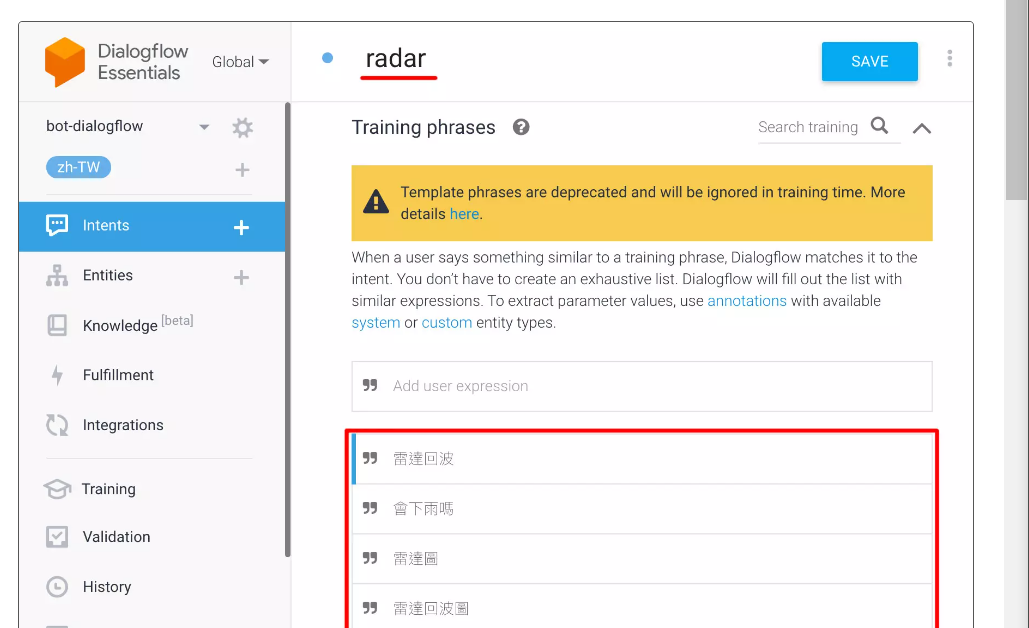

往下前往 Responses 區塊，輸入一個回應語句，因為待會會在 Webhook 伺服器端直接透過 Request 發送訊息，並不會使用到 Dialogflow 的回應，\
但因為串接需要有訊息內容，所以只需要一句即可，輸入後往下勾選 nable Webhook call for this intent。

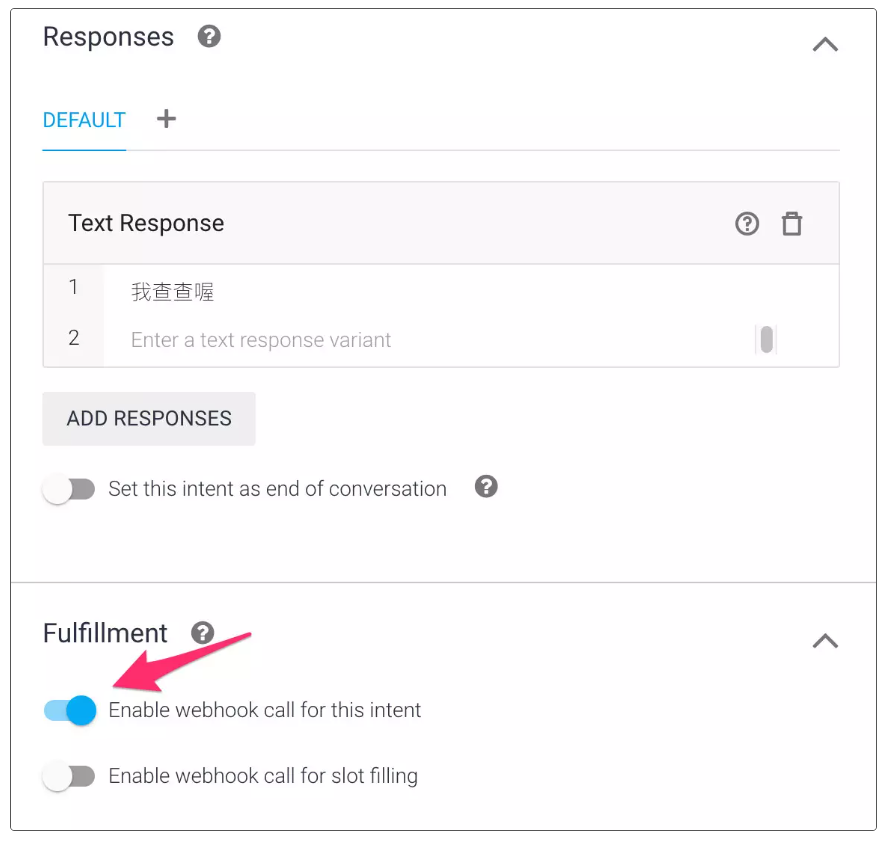

##### 回傳雷達回波圖 ( 本機環境 ) 
前往自己本機環境的 Webhook 伺服器程式 ( 參考「Dialogflow 串接 Webhook」 )，搭配「使用 Requests 傳送訊息」和「串接雷達回波圖」文章範例，\
判斷當收到的 intent 為 radar 時，使用 requests 函式庫直接回傳訊息 ( 參考「安裝 requests 模組」 )。

* 由於 LINE Reply Token 只能使用一次，因此使用 request 回傳訊息後，就無法再透過 Dialogflow 傳送訊息，因此 return 回 Dialogflow 的訊息就不包含 fulfillmentText。

In [ ]:
from flask import Flask, request
import requests, json, time

app = Flask(__name__)

@app.route("/")
def home():
    return "<h1>hello world</h1>"

@app.route('/webhook', methods=['POST'])
def webhook():
    req = request.get_json()
    print(req)
    reText = req['queryResult']['fulfillmentText']          # 取得 Dialogflow 的回應文字
    intent = req['queryResult']['intent']['displayName']    # 取得 intent 分類
    replytoken = req['originalDetectIntentRequest']['payload']['data']['replyToken']  # 取得 LINE replyToken
    token = '你的 LINE BOT Access Token'
    # 雷達回波圖網址，後方加上時間戳記，避免緩存
    img = f'https://cwbopendata.s3.ap-northeast-1.amazonaws.com/MSC/O-A0058-003.png?{time.time_ns()}'
    # 如果收到的 intent 是 radar
    if intent=='radar':
        headers = {'Authorization':'Bearer ' + token,'Content-Type':'application/json'}
        body = {
            'replyToken':replytoken,
            'messages':[{
                    'type': 'image',
                    'originalContentUrl': img,
                    'previewImageUrl': img
                }]
            }
        # 使用 requests 方法回傳訊息到 ＬINE
        result = requests.request('POST', 'https://api.line.me/v2/bot/message/reply',headers=headers,data=json.dumps(body).encode('utf-8'))
        print(result.text)
        # 完成後回傳訊息到 Dialogflow
        return {
            "source": "webhookdata"
        }
    # 如果收到的 intent 不是 radar
    else:
        # 使用 Dialogflow 產生的回應訊息
        return {
            "fulfillmentText": f'{reText} ( webhook )'
        }

app.run()

完成後啟動伺服器，除了可以在 LINE 裡與機器人聊天，也可以詢問雷達回波圖。

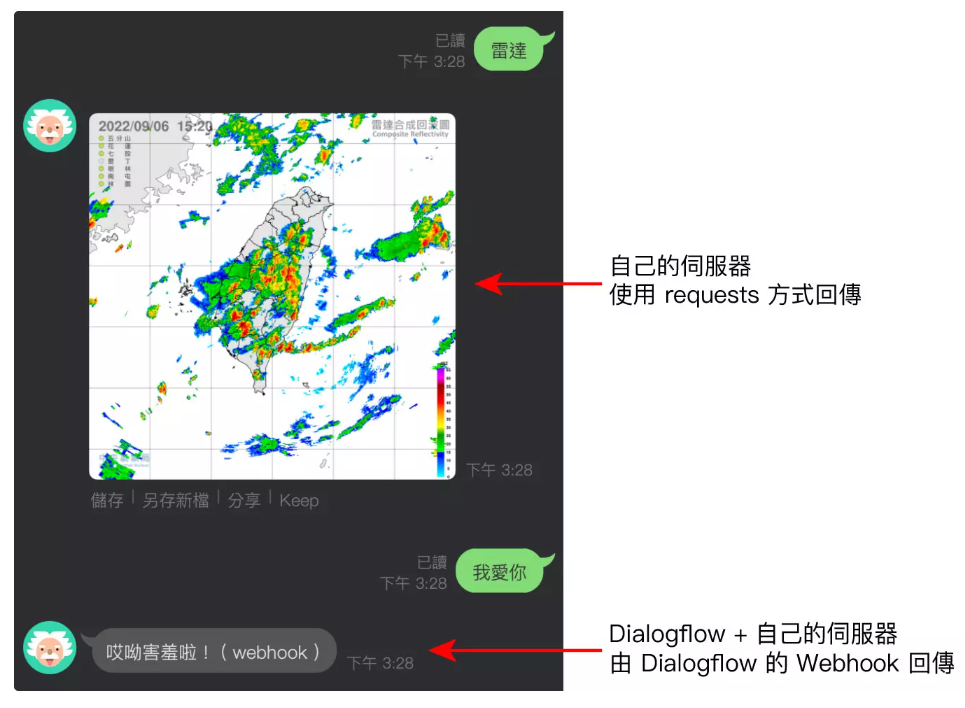

##### 回傳雷達回波圖 ( Colab ) 
如果要使用 Colab 產生 Webhook，請先參考「Google Colab 使用 ngrok」文章，在 Colab 裡安裝 ngrok，接著執行下方的程式碼\
( 和本機環境的差別只在於有多使用 flask_ngrok )

In [ ]:
from flask import Flask, request
import requests, json, time
from flask_ngrok import run_with_ngrok

app = Flask(__name__)

@app.route("/")
def home():
    return "<h1>hello world</h1>"

@app.route('/webhook', methods=['POST'])
def webhook():
    req = request.get_json()
    print(req)
    reText = req['queryResult']['fulfillmentText']          # 取得 Dialogflow 的回應文字
    intent = req['queryResult']['intent']['displayName']    # 取得 intent 分類
    replytoken = req['originalDetectIntentRequest']['payload']['data']['replyToken']  # 取得 LINE replyToken
    token = '你的 Access Token'
    # 雷達回波圖網址，後方加上時間戳記，避免緩存
    img = f'https://cwbopendata.s3.ap-northeast-1.amazonaws.com/MSC/O-A0058-003.png?{time.time_ns()}'
    # 如果收到的 intent 是 radar
    if intent=='radar':
        headers = {'Authorization':'Bearer ' + token,'Content-Type':'application/json'}
        body = {
            'replyToken':replytoken,
            'messages':[{
                    'type': 'image',
                    'originalContentUrl': img,
                    'previewImageUrl': img
                }]
            }
        # 使用 requests 方法回傳訊息到 ＬINE
        result = requests.request('POST', 'https://api.line.me/v2/bot/message/reply',headers=headers,data=json.dumps(body).encode('utf-8'))
        print(result.text)
        # 完成後回傳訊息到 Dialogflow
        return {
            "source": "webhookdata"
        }
    # 如果收到的 intent 不是 radar
    else:
        # 使用 Dialogflow 產生的回應訊息
        return {
            "fulfillmentText": f'{reText} ( webhook )'
        }

run_with_ngrok(app)     # 啟用 ngrok
app.run()

執行後，複製 ngrok 網址。

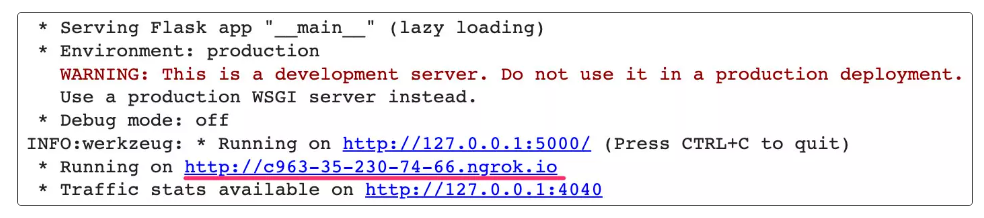

將網址貼回 Dialogflow 的 Fulfillment Webhook 網址裡 ( 注意，要改成 https )

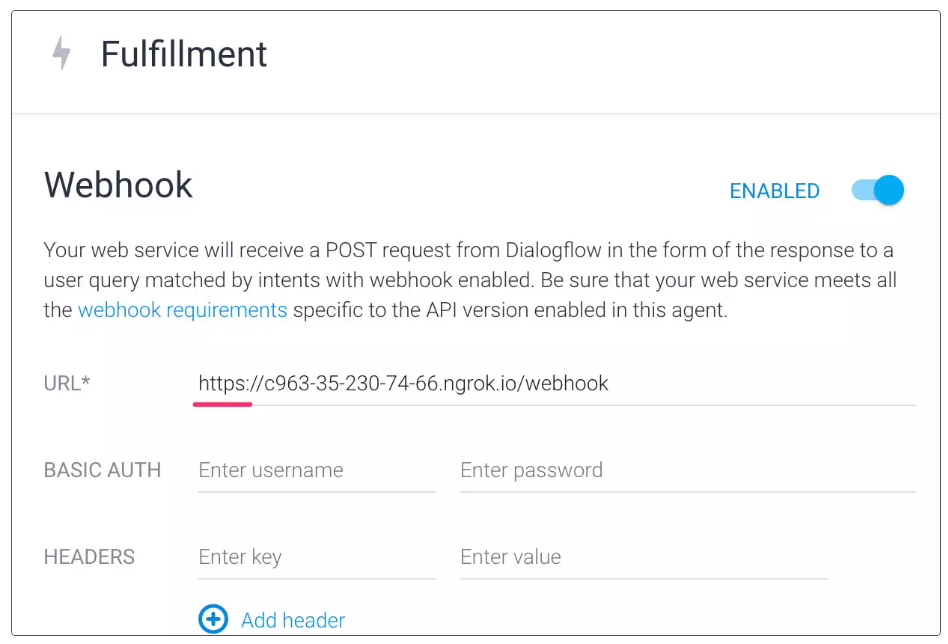

完成後就可以和 LINE 機器人聊天，詢問雷達回波圖。

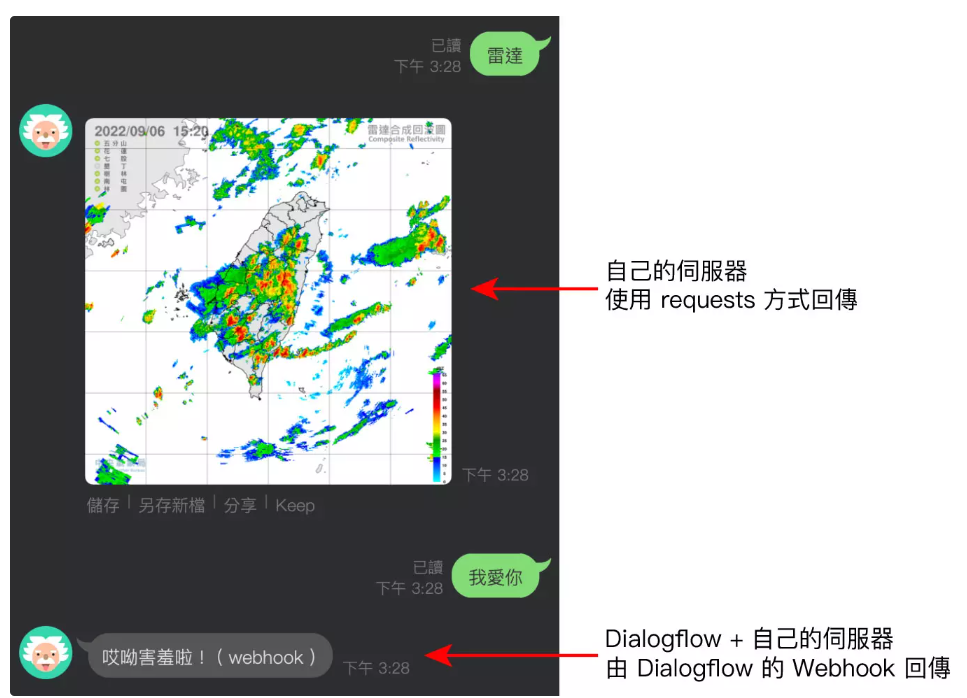

##### 回傳雷達回波圖 ( Cloud Functions ) 
透過 Google Cloud Functions 可以建立一個可以 24 小時運作的 Webhook 網址，在程式碼編輯的 main.py 輸入下方的程式碼 ( 參考「[使用 Google Cloud Functions](https://steam.oxxostudio.tw/category/python/example/google-cloud-functions.html)」 )。

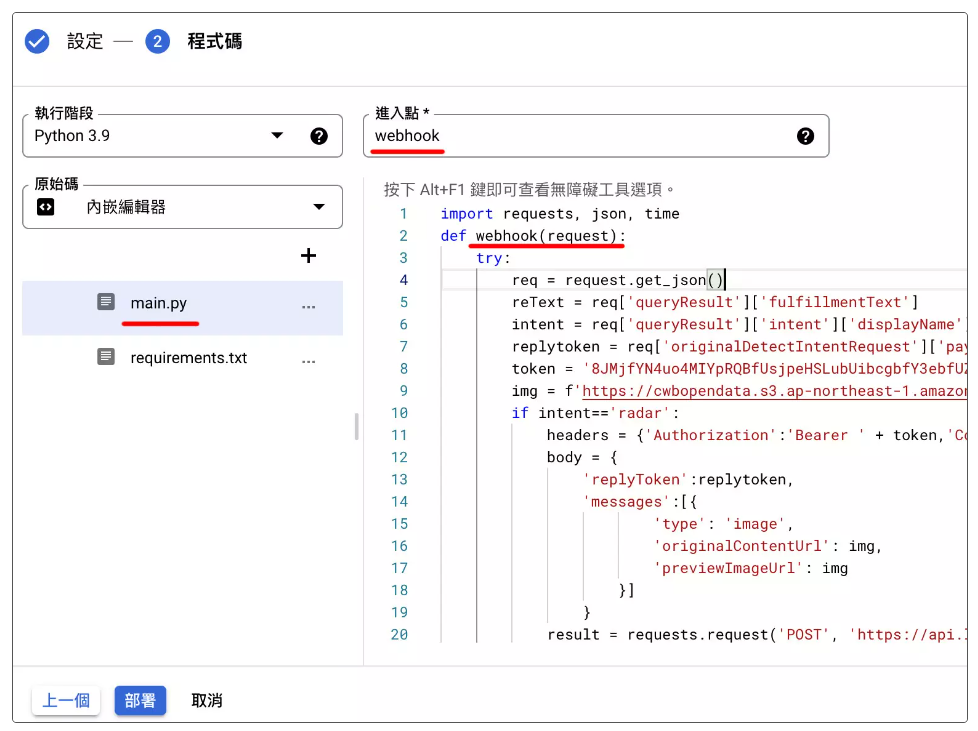

In [ ]:
import requests, json, time
def webhook(request):
    try:
        req = request.get_json()
        reText = req['queryResult']['fulfillmentText']
        intent = req['queryResult']['intent']['displayName']
        replytoken = req['originalDetectIntentRequest']['payload']['data']['replyToken']
        token = '你的 LINE BOT Access Token'
        img = f'https://cwbopendata.s3.ap-northeast-1.amazonaws.com/MSC/O-A0058-003.png?{time.time_ns()}'
        if intent=='radar':
            headers = {'Authorization':'Bearer ' + token,'Content-Type':'application/json'}
            body = {
                'replyToken':replytoken,
                'messages':[{
                        'type': 'image',
                        'originalContentUrl': img,
                        'previewImageUrl': img
                    }]
                }
            result = requests.request('POST', 'https://api.line.me/v2/bot/message/reply',headers=headers,data=json.dumps(body).encode('utf-8'))
            print(result.text)
            return {
                "source": "webhookdata"
            }
        else:
            return {
                "fulfillmentText": f'{reText} ( webhook )'
            }
    except:
        print(request.args)

因為 requests 為第三方函式庫，所以需要在 requirements.txt 裡添加 requests。

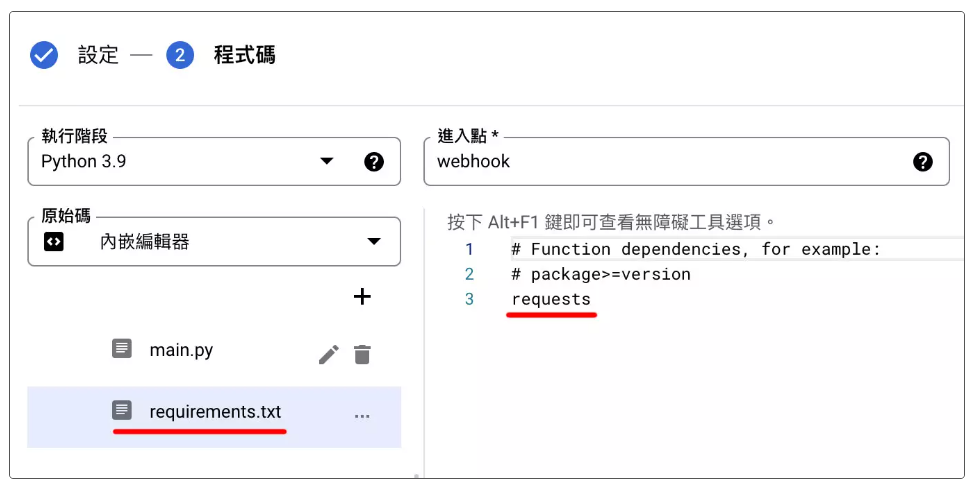

In [ ]:
# Function dependencies, for example:
# package>=version
requests

完成後如果成功部署，會出現綠色打勾圖示，複製觸發條件的 Webhook 網址。

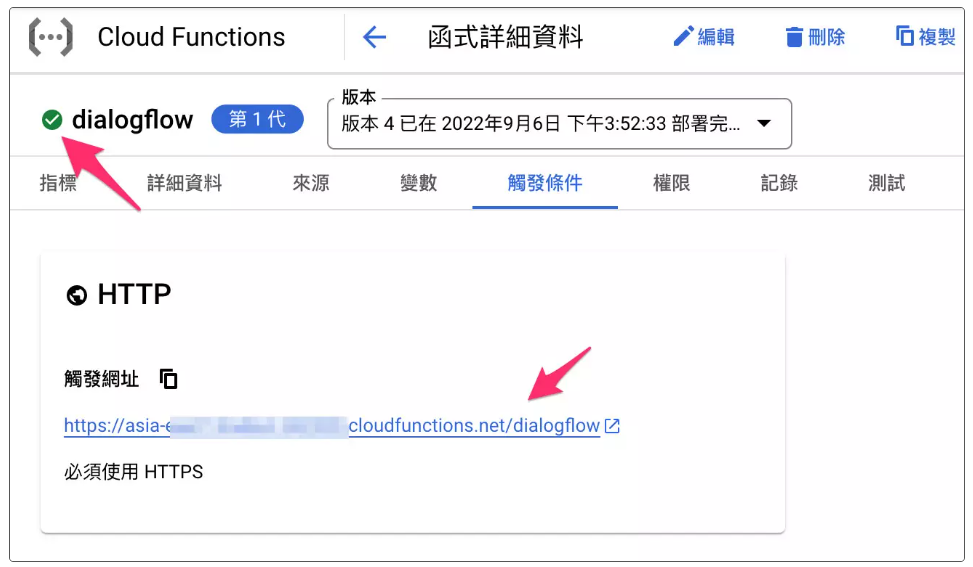

回到 Dialogflow 的 Fulfillment 頁籤，將網址貼到 Webhook 的 URL 欄位。

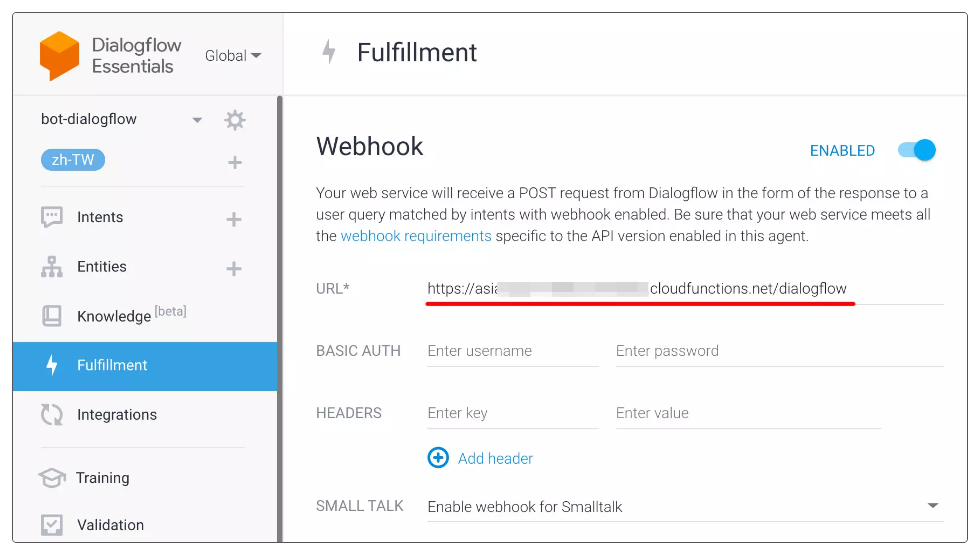

完成並儲存後，與 LINE BOT 聊天時，就會透過 Google Cloud Functions 進行邏輯判斷，並回傳雷達回波圖。

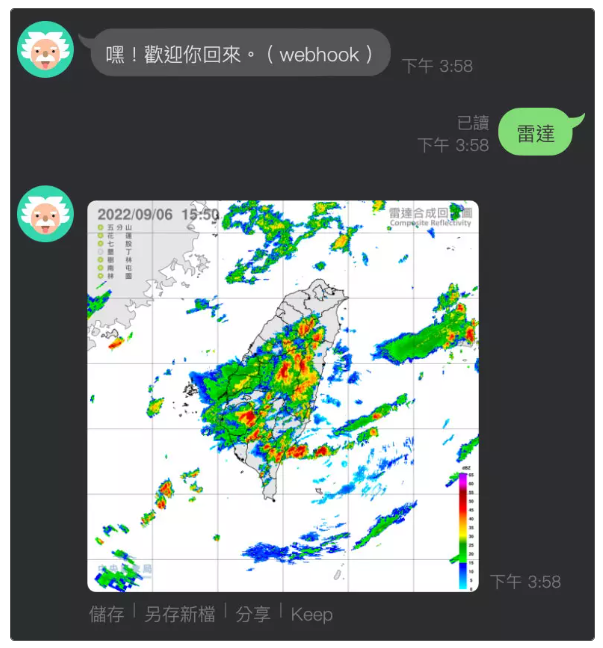